## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e dp do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [x] Calcular media e dp dos atrasos. 
- [x] Normalizar os atrasos calculados (atraso - atraso_medio)/dp
- [x] Construir matriz de correlação de Pearson
- [x] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas
- [ ] Separar um cojunto aleatório para teste
- [ ] Comparar pegando primeira UG e media por grupo
- [ ] Separar curvas para ACR e ACL


In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [2]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [3]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [4]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask_UHE_duplicate = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] = bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask_UHE_duplicate].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,DatConcretagemRealizado,DatMontagemOutorgado,DatMontagemRealizado,Torres_Outorga,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,,,,
5806,51590,2023-12-17,2024-01-01,NaT,NaT,BA,5300.0,2023-02-01,NaT,2023-04-01,NaT,2023-08-04,NaT,None,None,NaT,NaT,2023-02-01,NaT,EOL,1,5300.0,skate,2022-01-04
2828,32536,2023-12-02,2024-01-02,2021-12-01,2022-01-25,BA,33000.0,2022-12-01,2020-07-12,2023-03-07,2020-11-25,2023-06-05,2021-08-15,None,None,NaT,NaT,2023-12-02,2020-09-29,EOL,1,5500.0,skate,2019-01-21
4836,45022,2023-11-30,2024-01-31,NaT,NaT,RN,37260.0,2022-10-31,NaT,NaT,NaT,2022-12-31,NaT,None,None,NaT,NaT,2022-11-30,NaT,UFV,162,37260.0,skate,2019-12-17
4241,38199,2023-10-01,2023-12-01,NaT,NaT,CE,30000.0,2022-07-01,NaT,NaT,NaT,2022-11-01,NaT,None,None,NaT,NaT,2022-09-01,NaT,UFV,10,30000.0,skate,2021-06-29
1853,32322,2017-08-16,2017-10-01,2017-07-22,2017-12-29,BA,28.0,2016-07-03,2016-09-30,NaT,NaT,2016-09-01,2016-11-30,None,None,NaT,NaT,2017-03-21,2016-05-30,UFV,11,22.0,bdworgs,None
4804,44953,2024-01-05,2024-02-13,NaT,NaT,BA,30000.0,2023-03-20,NaT,2023-04-19,NaT,2023-07-15,NaT,None,None,NaT,NaT,2022-12-26,NaT,EOL,2,6000.0,skate,2021-05-18
2736,32305,2019-11-28,2019-12-23,NaT,NaT,SC,5700.0,2017-10-17,2019-03-15,2018-08-07,NaT,2018-12-11,NaT,None,None,2019-10-01,NaT,2018-08-07,NaT,PCH,1,2850.0,skate,2015-03-31
3049,33549,2024-12-02,2025-01-01,NaT,NaT,BA,72000.0,2024-02-01,2022-02-15,2024-04-01,NaT,2024-08-04,NaT,None,None,NaT,NaT,2024-02-01,2021-10-16,EOL,16,72000.0,skate,2020-04-09
3004,33508,2021-11-17,2022-01-01,2020-09-24,2020-10-16,BA,33600.0,2021-01-31,2019-06-01,2021-04-01,2019-10-15,2021-08-04,2020-07-27,None,None,NaT,NaT,2021-01-31,2019-03-28,EOL,1,4200.0,skate,2018-08-15


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [5]:
mask_OC_notna = bd_combined.DatUGInicioOpComerOutorgado.notna() & bd_combined.DatLiberOpComerRealizado.notna()
bd_combined = bd_combined[mask_OC_notna].copy(deep=True)

#### Cria dicionário com o tempo de cada marco a até a DatLiberOpComerRealizado por cada UG

In [6]:
dict_fase_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}

dict_marco_nome = {v: k for k, v in dict_fase_marco.items()}

#### Calcula o tempo por fase por UG

In [7]:
lst_infos = ["IdeUsinaOutorga","SigTipoGeracao","origem"]

tempo_fase_por_UG = bd_combined[lst_infos].copy(deep=True) #[["IdeUsinaOutorga","SigTipoGeracao","origem"]]
for nome,marco in dict_fase_marco.items():
    tempo_fase_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_fase_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"]
#tempo_fase_por_UG = pd.concat([tempo_fase_por_UG,bd_combined[list(dict_fase_marco.values()) + ["DatUGInicioOpComerOutorgado","DatLiberOpComerRealizado"]]],axis=1)
tempo_fase_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
5,42_2,UHE,bdworgs,1615 days,NaT,NaT,24 days,0 days
6,127,UTE,bdworgs,561 days,NaT,NaT,NaT,15 days
7,161,PCH,bdworgs,1163 days,677 days,NaT,38 days,2290 days
9,291,PCH,bdworgs,697 days,419 days,NaT,45 days,1676 days


#### Remove incosistências e gera tabela com motivos para eliminação

In [8]:
is_first = True 
combinacoes = list(combinations([x for x in dict_fase_marco.keys() ],2))
motivo_eliminacao = tempo_fase_por_UG[["SigTipoGeracao","origem","IdeUsinaOutorga"]].copy(deep=True)
motivo_eliminacao["motivo_eliminacao"] = ""

for p_marco, s_marco in combinacoes:
    mask_ordem_correta_parcial =  ((tempo_fase_por_UG[p_marco] >= tempo_fase_por_UG[s_marco]) | 
                 tempo_fase_por_UG[p_marco].isna() | 
                 tempo_fase_por_UG[s_marco].isna())
    
    motivo_eliminacao.loc[~mask_ordem_correta_parcial,"motivo_eliminacao"] += f"{s_marco[:-3]}>{p_marco[:-3]},"
    mask_ordem_correta = mask_ordem_correta_parcial if is_first else (mask_ordem_correta & mask_ordem_correta_parcial)
    is_first = False 
motivo_eliminacao =motivo_eliminacao[~mask_ordem_correta]
tempo_fase_por_UG_filtered = tempo_fase_por_UG[mask_ordem_correta].copy(deep=True)
tempo_fase_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5763,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5787,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5793,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


#### Gera tabelas de marcos e fases com apenas as primeiras UGs que entraram em OC. 

In [9]:
idx_primeira_ug =  bd_combined[mask_ordem_correta].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
# Considera apenas a primeira UG a entrar em OC
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
tempo_construcao_por_usina = tempo_fase_por_UG_filtered.loc[idx_primeira_ug,:]
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5763,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5787,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5793,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


####  

In [10]:
def divide(a,b):
    mask = a.notna()
    if len(a[mask])>0:
        a[mask] = a[mask]/b
    else:
        pass
    return a

tipos_geracao = bd_combined.SigTipoGeracao.unique()
tempo_construcao_por_usina_norm = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
dict_tempo_fase_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    dict_tempo_fase_mean_dp[SigTipoGeracao] = {}
    for tempo in ["IO_OC","CC_OC","ME_OC","OT_OC","Atraso"]:
        dict_tempo_fase_mean_dp[SigTipoGeracao][tempo] = {}
        mask = tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao
        m = (tempo_construcao_por_usina.loc[mask,tempo]).mean()
        s= (tempo_construcao_por_usina.loc[mask,tempo]).std()
        tempo_construcao_por_usina_norm.loc[mask,tempo] = divide((tempo_construcao_por_usina.loc[mask,tempo] - m),s)   
        dict_tempo_fase_mean_dp[SigTipoGeracao][tempo]["media"] = m
        dict_tempo_fase_mean_dp[SigTipoGeracao][tempo]["dp"] = s      
tempo_construcao_por_usina_norm.sample(15)

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
2198,34637,EOL,-0.253608,-0.148046,NaT,-0.555134,-0.201268
2042,33642,EOL,0.589647,0.785099,NaT,1.042174,-0.067688
1870,32346,EOL,-0.759561,-0.875064,NaT,0.845582,0.22408
1585,31559,EOL,-0.682147,-0.655009,NaT,-0.40769,-0.180176
715,29736_7,UHE,-0.083908,0.234677,0.250469,-0.14027,0.509537
3781,37020,EOL,-0.552203,-0.696792,-0.478675,0.673565,-0.354182
692,29721,PCH,-0.051348,-0.332419,-0.134843,-0.177853,-0.975158
1939,32923_0,UHE,-1.932685,-1.841513,-2.003572,-0.343461,-0.468707
2266,35721,UTE,-0.795331,NaT,-0.564014,-0.624178,-0.401316


In [11]:
is_first = True
th = 1.65
for i,SigTipoGeracao in enumerate(tipos_geracao):
    for nome_coluna in dict_fase_marco.keys():
        m_tc = dict_tempo_fase_mean_dp[SigTipoGeracao][nome_coluna]["media"]
        dp_tc = dict_tempo_fase_mean_dp[SigTipoGeracao][nome_coluna]["dp"]
        th_tc = (th*dp_tc)+m_tc
        outliers_parcial = ((tempo_construcao_por_usina[nome_coluna]) > th_tc)| ((tempo_construcao_por_usina[nome_coluna]) < -th_tc)
        outliers = outliers_parcial if is_first else (outliers & outliers_parcial)
tempo_construcao_por_usina = tempo_construcao_por_usina.loc[~outliers,:]

In [12]:
# Cria tabela para calculos por geracao
tempo_construcao_por_geracao = pd.DataFrame()
tempo_construcao_por_geracao["SigTipoGeracao"] = bd_combined.SigTipoGeracao.unique() 


# Realiza calculos por geracao
for coluna in tempo_construcao_por_usina.columns:
    if coluna not in ["IdeUsinaOutorga","SigTipoGeracao","origem"]:
        tempo_construcao_por_geracao[f"{coluna}_media"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[(tempo_construcao_por_usina.SigTipoGeracao==x)][coluna].mean())
        tempo_construcao_por_geracao[f"{coluna}_std"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].std())

tempo_construcao_por_geracao.set_index("SigTipoGeracao",inplace=True)
display(tempo_construcao_por_geracao)



,IO_OC_media,IO_OC_std,CC_OC_media,CC_OC_std,ME_OC_media,ME_OC_std,OT_OC_media,OT_OC_std,Atraso_media,Atraso_std
SigTipoGeracao,,,,,,,,,,
UHE,1830 days 06:58:54.545454560,616 days 03:06:31.864938248,1606 days 07:22:30,606 days 05:22:55.641656920,1502 days 04:29:25.161290320,624 days 19:21:29.932026856,40 days 05:53:34.285714285,28 days 19:00:22.876803095,192 days 22:12:37.894736842,553 days 13:21:09.371076896
UTE,657 days 01:57:00,809 days 10:43:12.303955008,NaT,NaT,508 days 21:16:21.818181816,890 days 08:01:47.195284528,48 days 06:20:47.416413374,40 days 14:49:50.021098232,239 days 00:16:27.428571428,713 days 09:06:58.541935752
PCH,856 days 06:27:41.538461536,511 days 13:52:41.455711176,623 days 08:47:44.921465968,479 days 14:40:49.750742552,373 days 12:12:20.571428572,258 days 03:19:21.894413132,44 days 07:57:58.991596638,32 days 08:24:05.323602353,978 days 13:12:36.302521008,1032 days 04:04:28.483458528
CGH,717 days 09:50:46.153846152,427 days 19:21:32.710725632,500 days 07:08:06.486486488,301 days 21:32:32.392932264,346 days 12:45:00,231 days 23:41:22.539763960,56 days 20:30:00,40 days 09:29:20.901978894,292 days 00:00:00,749 days 12:15:05.397272992
EOL,562 days 04:28:49.667149056,364 days 12:15:47.518544516,493 days 11:29:36.419213976,361 days 19:09:52.033846116,358 days 11:04:36.923076924,421 days 09:57:55.179180128,55 days 16:00:41.678726483,33 days 09:36:16.953567033,68 days 07:13:27.525325615,571 days 21:45:50.995544192
UFV,367 days 07:46:28.732394368,113 days 18:53:55.103687920,NaT,NaT,234 days 05:06:22.978723404,106 days 10:05:38.223244528,61 days 03:53:14.366197183,40 days 15:39:13.714230493,-4 days +07:16:03.380281691,294 days 07:35:09.656995008


In [13]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
def id_marco(ID,nome,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for nome,marco in dict_fase_marco.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,nome,marco))

In [14]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in dict_fase_marco.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

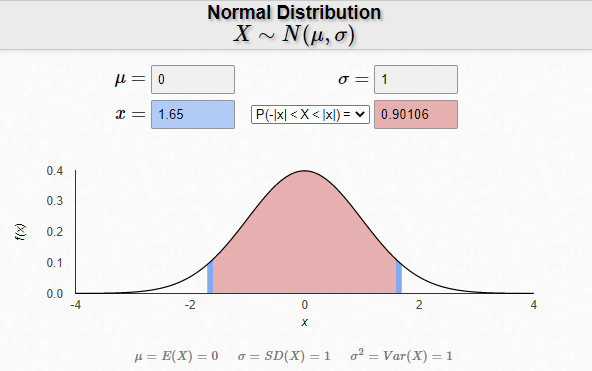

Não foi possível calcular: DatConcretagemRealizado_atraso para UTE: zero-size array to reduction operation minimum which has no identity
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV: zero-size array to reduction operation minimum which has no identity


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,63.4%,67.3%,36.1%,99.9%
UTE,82.3%,-,81.7%,99.8%
PCH,96.5%,97.0%,98.7%,100.0%
CGH,74.9%,88.9%,94.4%,99.9%
EOL,86.6%,86.6%,91.5%,99.9%
UFV,94.4%,-,94.5%,99.0%


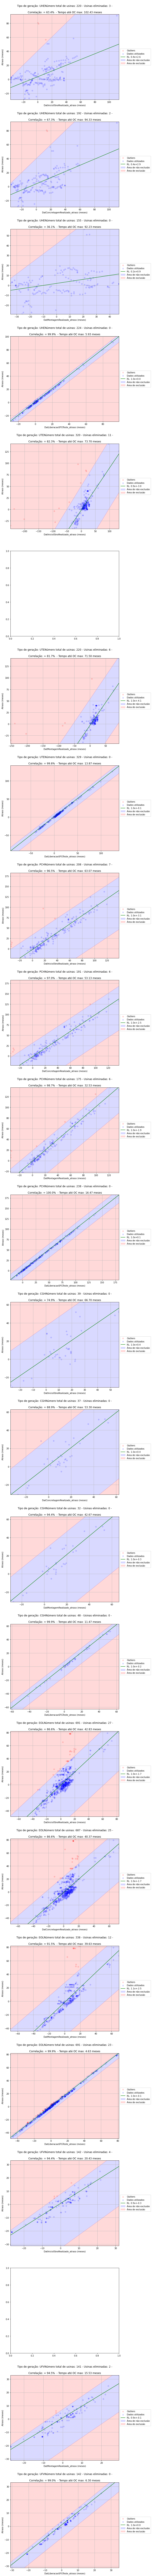

In [15]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]

matrix_pearson = {}
matrix_pearson_out = {}

def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str):
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]
    y = ordered_notna[y_name]
    try:
        x = x.dt.days.to_numpy()
        y = y.dt.days.to_numpy()
    except:
        pass
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy
    


th = 2
   
num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
fig, axes = plt.subplots(num_subplots,1,figsize=(10,num_subplots*7))
plot_created =True
count = -1
for i,SigTipoGeracao in enumerate(tipos_geracao):
    matrix_pearson[SigTipoGeracao] = []
    for nome_coluna in nomes_colunas_atrasos:
        count+=1
        ax = axes[count]
        try:
            # Máscara com apenas indices que correspondem ao tipo geração especificado
            idx_geracao = atraso_usina.SigTipoGeracao == SigTipoGeracao 
            # Todos pares x,y para o tipo geracao tal que: x = Atraso y = Atraso do marco especificado
            x1,y1 =  extract_xy(atraso_usina[idx_geracao], nome_coluna, "Atraso", nome_coluna)/30
            x_plot = np.linspace(x1.min()-10,x1.max()+10,100)
            m_tc = dict_tempo_fase_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["media"]
            dp_tc = dict_tempo_fase_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["dp"]
            th_tc = (th*dp_tc)+m_tc
            outliers = ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) > th_tc)| ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) < -th_tc)
            x2,y2 = extract_xy(atraso_usina[idx_geracao & outliers], nome_coluna, "Atraso", nome_coluna)/30
            x3,y3 = extract_xy(atraso_usina[idx_geracao & ~outliers], nome_coluna, "Atraso", nome_coluna)/30

            a, b, r, p_value, std_err = calc_regression(x3,y3)
            r_str = f"{100*r:.1f}%"

            # Converte para meses
            th_tc = th_tc.days/30
            m_tc = m_tc.days/30
            dp_tc = dp_tc.days/30

            # Plota resultados
            ax.scatter(x2,y2,color="red",alpha=0.15,label="Outliers")
            ax.scatter(x3,y3,color="blue",alpha=0.15,label="Dados utilizados")
            ax.plot(x_plot,a*x_plot+b+1,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
            ax.set_title(f"""\nTipo de geração: {SigTipoGeracao}Número total de usinas: {x1.shape[0]} - Usinas eliminadas: {x2.shape[0]} -\n\nCorrelação: = {r_str}  - Tempo até OC max: {th_tc:.2f} meses""")
            ax.grid()
            #ax.plot(x_plot,x_plot-m,linewidth=2)
            ax.fill_between(x_plot,x_plot-th_tc-m_tc,x_plot+th_tc-m_tc,color="blue",alpha=0.15,label="Área de não exclusão")
            ax.fill_between(x_plot,x_plot-th_tc-m_tc,y1.min(),color="red",alpha=0.15,label="Área de exclusão")
            ax.fill_between(x_plot,x_plot+th_tc-m_tc,y1.max(),color="red",alpha=0.15)
            ax.set_xlim(x1.min(),x1.max())
            ax.set_ylim(y1.min(),y1.max())
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_xlabel(f"{nome_coluna} (meses)")
            ax.set_ylabel(f"Atraso (meses)")
            matrix_pearson[SigTipoGeracao].append(r_str)
        except (ValueError,AttributeError) as error:
            print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}: {error}")
            matrix_pearson[SigTipoGeracao].append("-")
                
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)